In [1]:
from datetime import datetime, timedelta
from netCDF4 import Dataset


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob

import numpy as np
import math


from netCDF4 import Dataset

import pandas as pd
import xarray as xr

from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
import metpy.plots as mpplots
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar

In [2]:
UNIX_TIME = datetime(1970,1,1,0)

In [3]:
#set time to plot
start_year  = 2020
start_month = 11
start_day   = 7
start_hour  = 0
#start_min   = 0
    
#set plot domain
lat_min = 22
lat_max = 50
lon_min = -124
lon_max = -70
    
dt = datetime(start_year,start_month,start_day,start_hour)
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)
print(del_t_days)

894.8407407407408


In [4]:
#get the data
import requests
import gzip
import shutil

#download and extract the data

if del_t_days>3:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/raob/netcdf/{dt:%Y%m%d_%H%M}.gz'
    print(url)
    r = requests.get(url,allow_redirects=True)
    open('temp.nc.gz','wb').write(r.content)
    with gzip.open('temp.nc.gz','rb') as f_in:
        with open('temp.nc','wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    data=Dataset('temp.nc','r')

else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/raob/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'
    print(url)
    r = requests.get(url,allow_redirects=True)
    open('temp.nc.gz','wb').write(r.content)
    with gzip.open('temp.nc.gz','rb') as f_in:
        with open('temp.nc','wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    data=Dataset('temp.nc','r')

https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/2020/11/07/point/raob/netcdf/20201107_0000.gz


In [5]:
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['synTime']]
lat = data['staLat'][:]
lat = lat.filled(np.nan)
lon = data['staLon'][:]
lon = lon.filled(np.nan)
pres = data['prMan'][:]
pres = pres.filled(np.nan)
hght = data['htMan'][:]
hght = hght.filled(np.nan)
temp = data['tpMan'][:]
temp = temp.filled(np.nan)
temp[temp<100]=np.nan
temp = (temp-273.15)
dwptdp = data['tdMan'][:]
dwptdp = dwptdp.filled(np.nan)
dwptdp[dwptdp<100]=np.nan
dwptdp = (dwptdp-273.15)
wdir = data['wdMan'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan
wspd = data['wsMan'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan

name = data['staName'][:]
name = [i.tostring().decode()[:4] for i in name]
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

#u = np.abs(wspd) * np.cos(np.deg2rad(270-wdir))
#u[np.abs(u)>250] = np.nan
#v = np.abs(wspd) * np.sin(np.deg2rad(270-wdir))
#v[np.abs(v)>250] = np.nan

#u=u*units['kts']
#v=v*units['kts']
#df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwptdp,pres,hght])),
 #                     columns = ['time','id','name','lon','lat','u','v','temp','dwptdp','pres','hght'])

print(len(name))

ds = xr.Dataset(
        coords=dict(
            id=(['id'],name)
            ),
        data_vars=dict(
            lon=(['id'],lon),
            lat=(['id'],lat),
            pressure=(['id','pres'],pres),
            height=(['id','pres'],hght),
            temperature=(['id','pres'],temp),
            dwptdp=(['id','pres'],dwptdp),
            u=(['id','pres'],u),
            v=(['id','pres'],v)
            )
    )

#convert to pandas dataframe and remove obs with nans for lat/lon
df=ds.to_dataframe()
df=df[df['lat'].notna()]
df=df[df['lon'].notna()]
print(df)

402
                 lon    lat  pressure       height  temperature  dwptdp  \
id   pres                                                                 
7880 0    -79.580002   8.98    1008.0     7.000000    27.000000     NaN   
     1    -79.580002   8.98    1000.0    75.000000    26.200012     NaN   
     2    -79.580002   8.98     925.0   757.959167    20.399994     NaN   
     3    -79.580002   8.98     850.0  1487.959106    19.399994     NaN   
     4    -79.580002   8.98     700.0  3137.040771    11.800018     NaN   
...              ...    ...       ...          ...          ...     ...   
CYLT 17   -62.349998  82.50       NaN          NaN          NaN     NaN   
     18   -62.349998  82.50       NaN          NaN          NaN     NaN   
     19   -62.349998  82.50       NaN          NaN          NaN     NaN   
     20   -62.349998  82.50       NaN          NaN          NaN     NaN   
     21   -62.349998  82.50       NaN          NaN          NaN     NaN   

                  u 

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_24958/3830421368.py:26: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  name = [i.tostring().decode()[:4] for i in name]


### Subset based on vertical level
Users can choose between mandatory levels (1000, 925, 850, 700, 500, 400, 300, 250, and 200 mb) to plot. The data gets put into a subset based on the pressure level.

In [6]:
df_sub = df[df['pressure']==200]
print(df_sub)
print(len(df_sub))
#df_var = df_sub['temperature']
#print("temperatures:")
#print(df_var)
#df_var = df_sub[['lon','lat','temperature']].copy()
#print(df_var)

                  lon        lat  pressure   height  temperature  dwptdp  \
id   pres                                                                  
7880 9     -79.580002   8.980000     200.0  12460.0   -52.299988     NaN   
MKPP 9     -61.349998  10.580000     200.0  12470.0   -54.099991     NaN   
MCSP 9     -81.699997  12.580000     200.0  12460.0   -51.899994     NaN   
MACA 9     -99.930000  16.830000     200.0  12460.0   -52.899994     NaN   
MZBZ 9     -88.300003  17.530001     200.0  12440.0   -52.500000     NaN   
...               ...        ...       ...      ...          ...     ...   
CYUX 9     -81.250000  68.779999     200.0  10980.0   -53.699997     NaN   
CYCB 9    -105.120003  69.099998     200.0  11010.0   -51.699997     NaN   
CYRB 9     -94.970001  74.699997     200.0  10910.0   -53.899994     NaN   
CWEU 9     -85.930000  80.000000     200.0  10880.0   -52.500000     NaN   
CYLT 14    -62.349998  82.500000     200.0  10970.0   -54.299988     NaN   

           

###

In [ ]:
successive_corrections = True
search_radius = 300000 #only used if successive_corrections is false

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

hghtdf = df_sub.dropna(subset=['height'],inplace=False)
    
point_locs = proj.transform_points(ccrs.PlateCarree(),df_sub['lon'].values,df_sub['lat'].values)
point_locs_hght = proj.transform_points(ccrs.PlateCarree(),hghtdf['lon'].values,hghtdf['lat'].values)

xp,yp,null = point_locs_hght.T
    
if successive_corrections:
    ROIs = [500000,400000,300000,200000]
    #first pass
    hghtgridx, hghtgridy, height = interpolate_to_grid(xp,yp,hghtdf['height'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=20000,search_radius=ROIs[0])
    HEIGHT = np.zeros((len(ROIs),len(height),len(height[0])))
    HEIGHT[0] = height
    grid = np.transpose([hghtgridx.ravel(),hghtgridy.ravel()])
    stns = np.transpose([xp,yp])
    for i in range(1,len(ROIs)):
        #interpolate gridded slp to obs locations:
        hght_bg = interpolate_to_points(grid,HEIGHT[i-1].ravel(),stns,interp_type='cressman',search_radius=ROIs[i-1])
        
        #calculate next pass
        hghtgridx, hghtgridy, height = interpolate_to_grid(xp,yp,hghtdf['height']-hght_bg,interp_type='cressman',minimum_neighbors=1,hres=20000,search_radius=ROIs[i])
        HEIGHT[i] = np.nansum([hght,HEIGHT[i-1]],axis=0)
        height = HEIGHT[i]
        
else:
    hghtgridx, hghtgridy, height = interpolate_to_grid(xp,yp,hghtdf['height'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=20000,search_radius=search_radius)

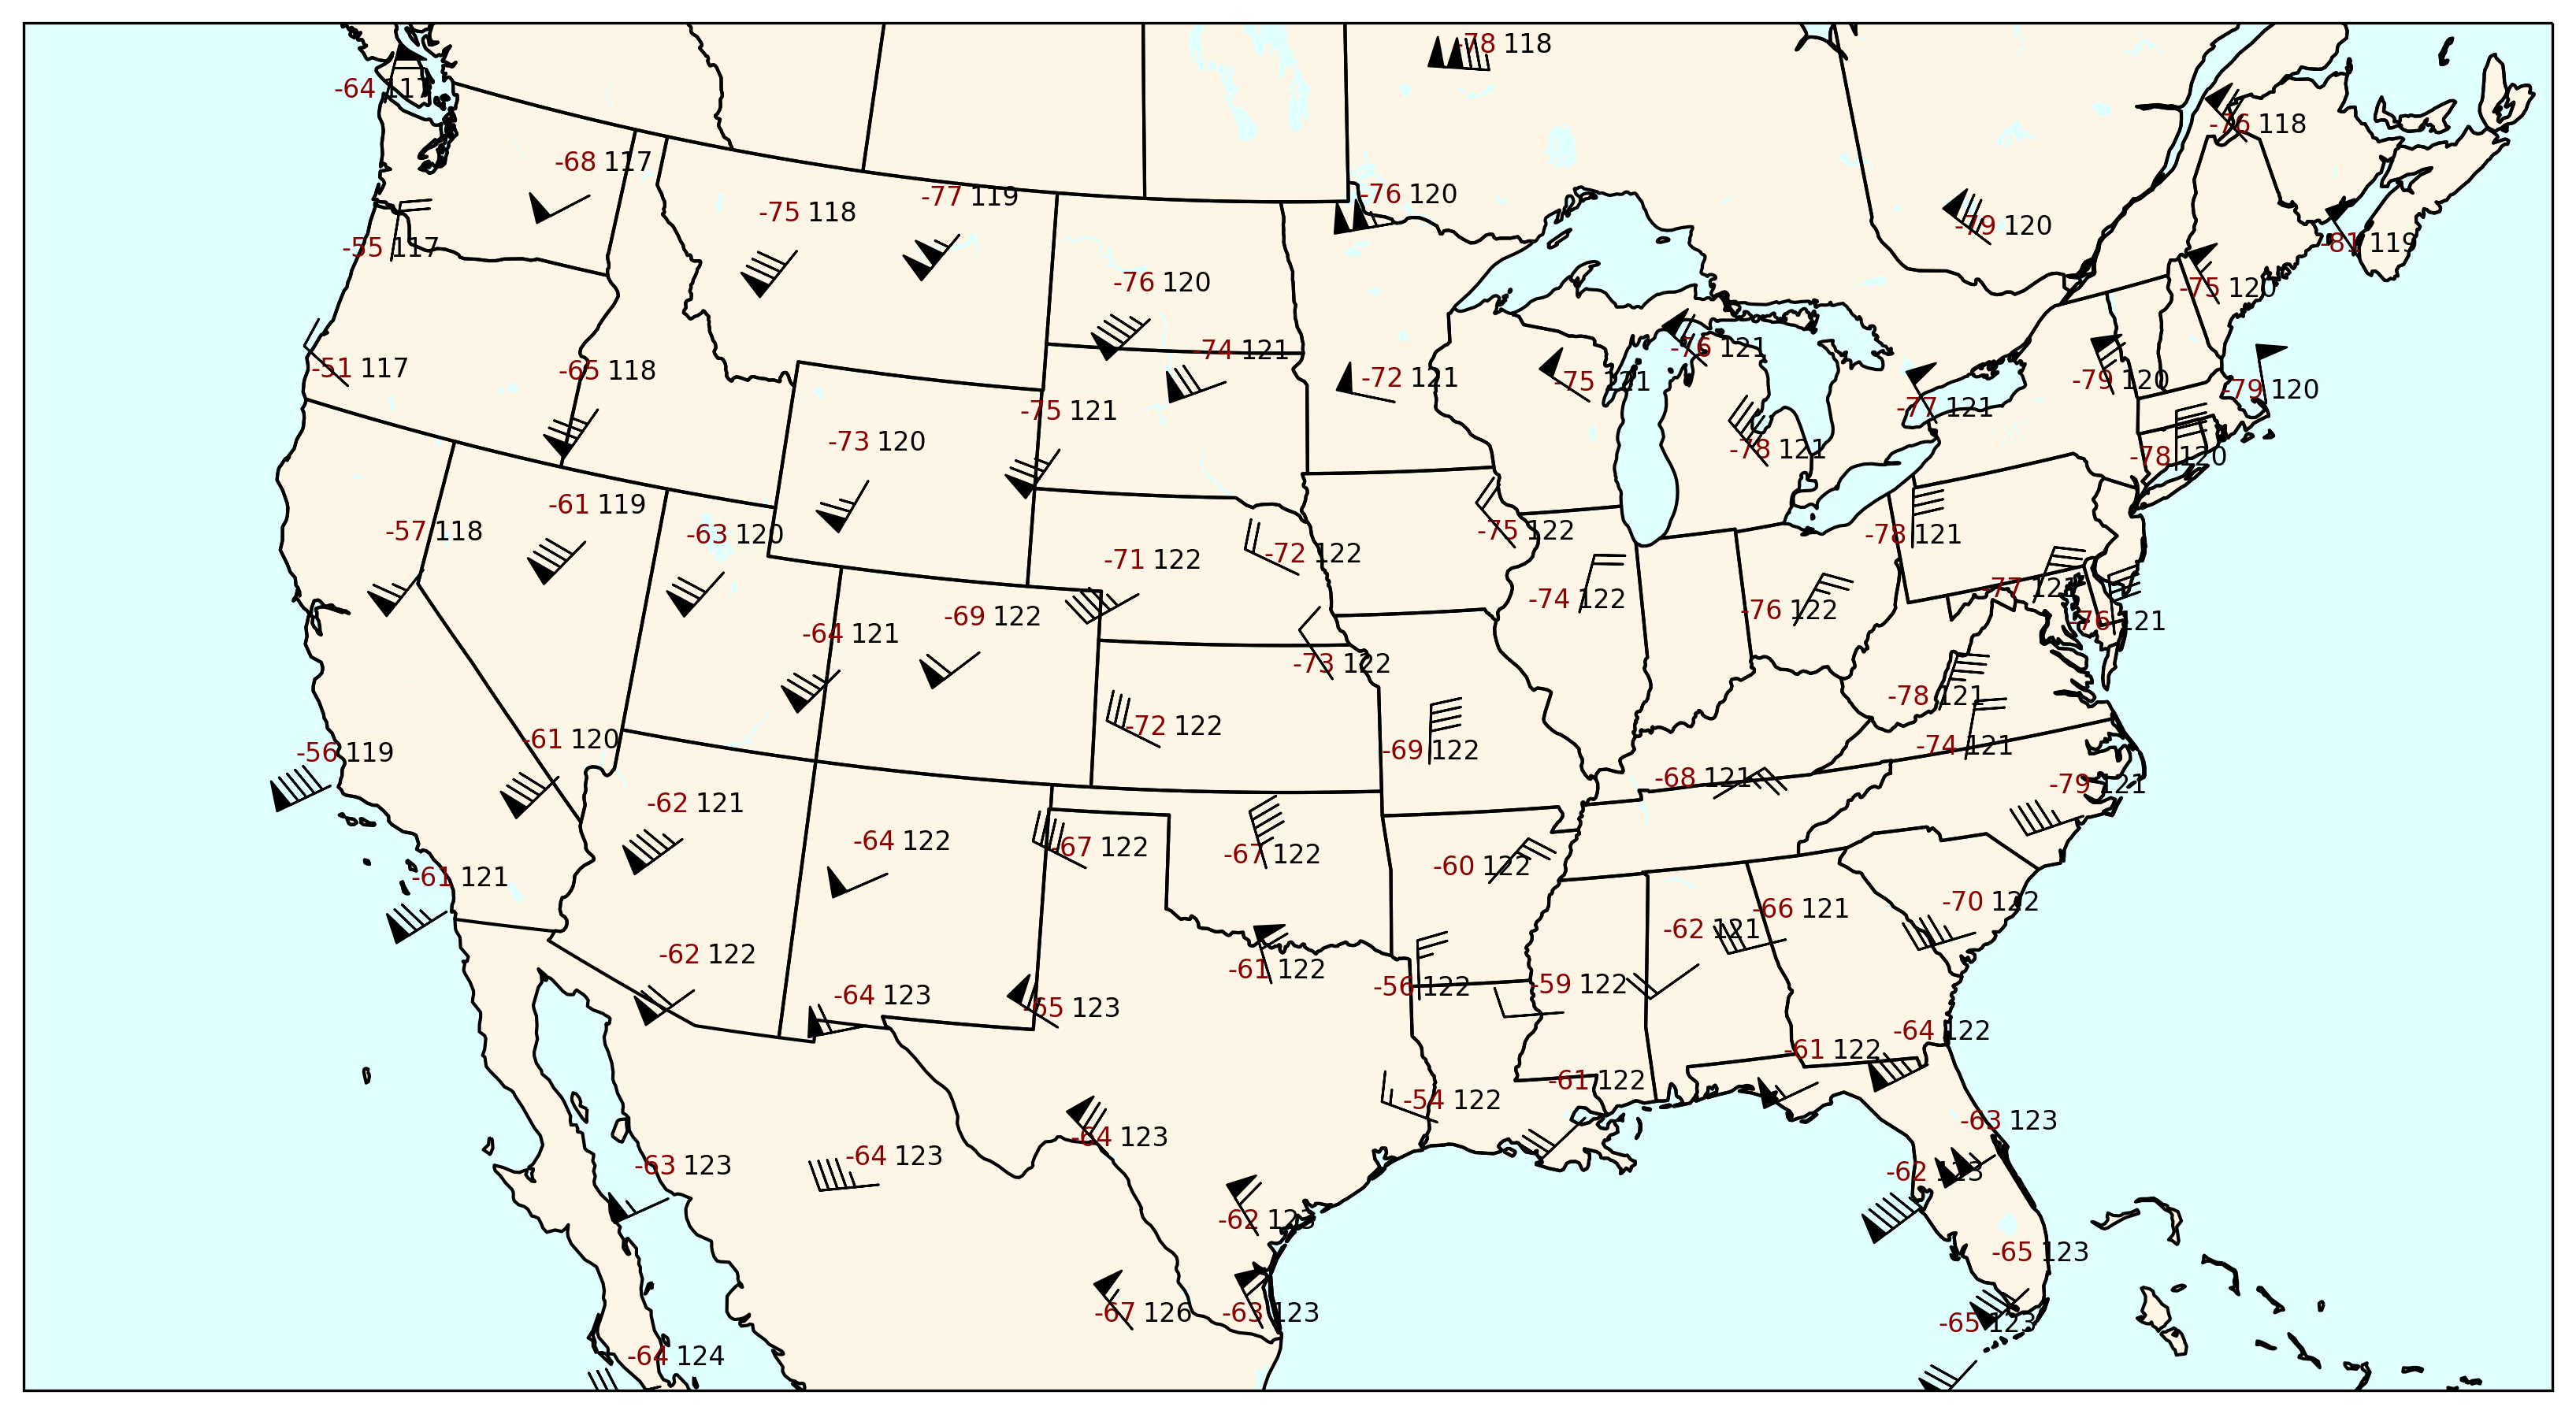

In [149]:
fig=plt.figure(figsize=(11,6.5),dpi=300)
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
ax = fig.add_subplot(1,1,1,projection=proj)
#img = plt.imread('../basemaps/natural_earth.tif')
#img_extent = (-180,180,-90,90)
#ax.imshow(img,origin='upper',extent=img_extent,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
#stationplot.plot_text((2.1,0),df_plot['name'].values,fontsize=4,color='gray')
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
cs = plt.contour(hghtgridx,hghtgridy,height,colors='k',levels=list(range(900,1034,4)),linewidths=1)
#plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
#stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
#stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)
#plt.suptitle(dt_str)
fig.tight_layout()

plt.show()